# MCCT with AE and lr scheduler

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #my python installation is kinda messy, please allow this
import torch
if not torch.cuda.is_available():
    quit()
else:
    print("Cuda capable device found!")

Cuda capable device found!


In [2]:
ds_selector='.\\datasets\\CICDDoS2019\\CORRECT_CUT'

In [3]:
csv_files = []
for dirname, _, filenames in os.walk(ds_selector):
    for filename in filenames:
        csv_file = os.path.join(dirname, filename)
        csv_files.append(csv_file)
csv_files

['.\\datasets\\CICDDoS2019\\CORRECT_CUT\\fair_cut.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\unified_jumbo.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes\\BENIGN\\BENIGN.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes\\DNS\\DNS.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes\\LDAP\\LDAP.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes\\MSSQL\\MSSQL.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes\\NetBIOS\\NetBIOS.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes\\NTP\\NTP.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes\\SNMP\\SNMP.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes\\SSDP\\SSDP.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes\\Syn\\Syn.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes\\TFTP\\TFTP.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes\\UDP\\UDP.csv',
 '.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes\\UDPLag\\UDPLag.csv']

In [4]:
csv_files = ['.\\datasets\\CICDDoS2019\\CORRECT_CUT\\fair_cut.csv']
if len(csv_files) > 1:
    df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
else:
    df = pd.read_csv(csv_files[0])
    
df.columns = df.columns.str.strip()
print("Original length of df:", len(df))

Original length of df: 1352772


In [5]:
#df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352772 entries, 0 to 1352771
Data columns (total 80 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Destination Port             1352772 non-null  int64  
 1   Flow Duration                1352772 non-null  int64  
 2   Total Fwd Packets            1352772 non-null  int64  
 3   Total Backward Packets       1352772 non-null  int64  
 4   Total Length of Fwd Packets  1352772 non-null  float64
 5   Total Length of Bwd Packets  1352772 non-null  float64
 6   Fwd Packet Length Max        1352772 non-null  float64
 7   Fwd Packet Length Min        1352772 non-null  float64
 8   Fwd Packet Length Mean       1352772 non-null  float64
 9   Fwd Packet Length Std        1352772 non-null  float64
 10  Bwd Packet Length Max        1352772 non-null  float64
 11  Bwd Packet Length Min        1352772 non-null  float64
 12  Bwd Packet Length Mean       1352772 non-n

In [6]:
"""df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("After dropping NaNs, the length of df:", len(df))
df.drop_duplicates(keep='first', inplace=True)"""

'df.replace([np.inf, -np.inf], np.nan, inplace=True)\ndf.dropna(inplace=True)\nprint("After dropping NaNs, the length of df:", len(df))\ndf.drop_duplicates(keep=\'first\', inplace=True)'

In [7]:
"""for col in df.columns:
    if len(df[col].unique()) == 1:
        print('Removing column', str(col))
        df.drop(col,inplace=True,axis=1)"""

"for col in df.columns:\n    if len(df[col].unique()) == 1:\n        print('Removing column', str(col))\n        df.drop(col,inplace=True,axis=1)"

In [8]:
df.Label.value_counts()

BENIGN     112731
DNS        112731
LDAP       112731
MSSQL      112731
NetBIOS    112731
NTP        112731
SNMP       112731
SSDP       112731
Syn        112731
TFTP       112731
UDP        112731
UDPLag     112731
Name: Label, dtype: int64

C:\Users\MAX\AppData\Local\Temp\ipykernel_8296\2263113112.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat=df.corr()


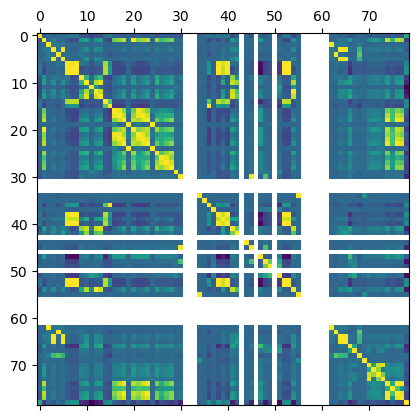

In [9]:
corr_mat=df.corr()
plt.matshow(corr_mat)
plt.show()

In [10]:
cols=df.columns.to_list()
print(cols)
print(len(cols))

['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

In [11]:
for i in range(len(df.columns)):
    if cols[i] != 'Label':
        print(i, cols[i], ', Std:', df.iloc[:,i].std(), ', Avg:', df.iloc[:,i].mean())

0 Destination Port , Std: 20105.976448412795 , Avg: 30998.746487952147
1 Flow Duration , Std: 11817897.20171718 , Avg: 2116002.844284181
2 Total Fwd Packets , Std: 222.02923853078465 , Avg: 8.82712016511282
3 Total Backward Packets , Std: 32.19893427136701 , Avg: 0.8107515531072494
4 Total Length of Fwd Packets , Std: 19456.412990897934 , Avg: 3679.1860320881865
5 Total Length of Bwd Packets , Std: 60578.19942889997 , Avg: 556.446286587836
6 Fwd Packet Length Max , Std: 541.0232997132838 , Avg: 583.9448465816856
7 Fwd Packet Length Min , Std: 543.1249334027852 , Avg: 560.1538004926181
8 Fwd Packet Length Mean , Std: 537.3158103815878 , Avg: 570.9523869080766
9 Fwd Packet Length Std , Std: 42.446998747370415 , Avg: 8.586602142883406
10 Bwd Packet Length Max , Std: 283.8163802203857 , Avg: 26.564854240034535
11 Bwd Packet Length Min , Std: 19.212298081181125 , Avg: 2.9127465677882154
12 Bwd Packet Length Mean , Std: 73.64542159755085 , Avg: 8.683555098738644
13 Bwd Packet Length Std , St

In [12]:
%store -r classes_distribution_cut
classes_ids={}
classes_ids=classes_ids.fromkeys(classes_distribution_cut)

one_hot_encoding=torch.nn.functional.one_hot(torch.arange(0,len(classes_distribution_cut)),num_classes=len(classes_distribution_cut))
one_hot_encoding

for idx,(k,_) in enumerate(classes_ids.items()):
    classes_ids[k]=(idx,one_hot_encoding[idx])

classes_ids

{'DNS': (0, tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 'BENIGN': (1, tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 'LDAP': (2, tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 'MSSQL': (3, tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])),
 'NetBIOS': (4, tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])),
 'NTP': (5, tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])),
 'SNMP': (6, tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])),
 'SSDP': (7, tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])),
 'UDP': (8, tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])),
 'Syn': (9, tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])),
 'TFTP': (10, tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])),
 'UDPLag': (11, tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))}

In [13]:
replacement_dict={}
replacement_dict_cass_to_id={}
replacement_dict.fromkeys(classes_ids)
for k,(idx, tensor) in classes_ids.items():
    replacement_dict[idx]=tensor
    replacement_dict_cass_to_id[k]=idx

replacement_dict

{0: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 1: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 2: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 3: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 4: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 5: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 6: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 7: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 8: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 9: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 10: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 11: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])}

In [14]:
replacement_dict_cass_to_id

{'DNS': 0,
 'BENIGN': 1,
 'LDAP': 2,
 'MSSQL': 3,
 'NetBIOS': 4,
 'NTP': 5,
 'SNMP': 6,
 'SSDP': 7,
 'UDP': 8,
 'Syn': 9,
 'TFTP': 10,
 'UDPLag': 11}

In [15]:
df.replace({'Label':replacement_dict_cass_to_id}, inplace=True)
X=df.iloc[:,:79]
Y=df.iloc[:,79]

In [16]:
tot_col=df.columns.tolist()
tot_col=[(idx,x) for idx,x in enumerate(tot_col)]
tot_col

[(0, 'Destination Port'),
 (1, 'Flow Duration'),
 (2, 'Total Fwd Packets'),
 (3, 'Total Backward Packets'),
 (4, 'Total Length of Fwd Packets'),
 (5, 'Total Length of Bwd Packets'),
 (6, 'Fwd Packet Length Max'),
 (7, 'Fwd Packet Length Min'),
 (8, 'Fwd Packet Length Mean'),
 (9, 'Fwd Packet Length Std'),
 (10, 'Bwd Packet Length Max'),
 (11, 'Bwd Packet Length Min'),
 (12, 'Bwd Packet Length Mean'),
 (13, 'Bwd Packet Length Std'),
 (14, 'Flow Bytes/s'),
 (15, 'Flow Packets/s'),
 (16, 'Flow IAT Mean'),
 (17, 'Flow IAT Std'),
 (18, 'Flow IAT Max'),
 (19, 'Flow IAT Min'),
 (20, 'Fwd IAT Total'),
 (21, 'Fwd IAT Mean'),
 (22, 'Fwd IAT Std'),
 (23, 'Fwd IAT Max'),
 (24, 'Fwd IAT Min'),
 (25, 'Bwd IAT Total'),
 (26, 'Bwd IAT Mean'),
 (27, 'Bwd IAT Std'),
 (28, 'Bwd IAT Max'),
 (29, 'Bwd IAT Min'),
 (30, 'Fwd PSH Flags'),
 (31, 'Bwd PSH Flags'),
 (32, 'Fwd URG Flags'),
 (33, 'Bwd URG Flags'),
 (34, 'Fwd Header Length'),
 (35, 'Bwd Header Length'),
 (36, 'Fwd Packets/s'),
 (37, 'Bwd Packets/s'

In [17]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, Y, shuffle=True, train_size=0.75)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, shuffle=True, train_size=0.75)

del X,Y,df
gc.collect()

trainY=pd.Series(trainY)
valY=pd.Series(valY)

f:\miniconda\envs\dl\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [18]:
from sklearn.preprocessing import StandardScaler
scalerX_train = StandardScaler()
X_scaled_train=scalerX_train.fit_transform(trainX)

In [19]:
from torch import tensor
from torch.utils.data import Dataset, DataLoader

class NetMetrics(Dataset):
    def __init__(self, X, y, one_hot):
        self.x, self.y, self.one_hot = X, y, one_hot
        self.len=self.x.shape[0]

    def __getitem__(self,index):
        tensor_label=one_hot_encoding[self.y.iloc[index]]
        return tensor(self.x[index,:], dtype=torch.float32), tensor_label.float()
        
    def __len__(self):
        return self.len

ds=NetMetrics(X_scaled_train, trainY, replacement_dict)

## The model

In [36]:
class AttackNet(torch.nn.Module):
    def __init__(self):
        super(AttackNet, self).__init__()
        self.encoder=torch.nn.Sequential(
            torch.nn.Linear(79, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 40)
            )
        self.decoder=torch.nn.Sequential(
            torch.nn.Linear(40, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 79)
            )
        self.classifier=torch.nn.Sequential(
            torch.nn.Linear(40, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 12),
            torch.nn.LogSoftmax(dim=1)
            )

    def forward(self, x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        out=self.classifier(encoded)
        return decoded, out

def init_weights(module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.fill_(0.0001)


model = AttackNet()
model.apply(init_weights)

AttackNet(
  (encoder): Sequential(
    (0): Linear(in_features=79, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=79, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=40, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=12, bias=True)
    (9): LogSoftmax(dim=1)
  )
)

In [38]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Training

In [39]:
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

epochs=50
learning_rate = .001
model=model.to(device)
criterion1 = torch.nn.MSELoss().to(device)
criterion2 = torch.nn.CrossEntropyLoss().to(device)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)
loader = DataLoader(dataset=ds, batch_size=100, shuffle=True)

# Early stopping
last_loss = np.inf
patience = 2
trigger_times = 0

In [49]:
def model_validation(criterion_dec, criterion_out):

    #val_tar=[]
    #val_pred=[]
    cumulative_L_val=0.

    val_ds = NetMetrics(scalerX_train.transform(testX), testY, replacement_dict)
    val_loader=DataLoader(val_ds, batch_size=100, shuffle=False)

    model.eval()

    with torch.no_grad():
        for inputs, ground_truth in val_loader:
            inputs = inputs.to(device)
            ground_truth = ground_truth.to(device)

            decoded_tilde, y_tilde = model(inputs)
            decoded_tilde = decoded_tilde.to(device)
            y_tilde = y_tilde.to(device)
            
            loss1_val = criterion_dec(decoded_tilde, inputs)
            loss2_val = criterion_out(y_tilde, ground_truth)
            loss_val = loss1_val+loss2_val
            
            cumulative_L_val+=loss_val.item()
           
            #val_tar.append(y)
            #val_pred.append(y_tilde.clone().detach())
    
        #f1=BinaryF1Score()
        #f1_val=f1(tensor(val_pred), tensor(val_tar))

        #print('F1-score Val: ', f1_val)
    
    #return f1_val
    return cumulative_L_val

In [50]:
def model_train(epoch, optimizer, model):
    model.train()
    
    print("Epoch begin: ", epoch)
    cumulative_L_train = 0.
    for x,y in loader:
        x=x.to(device)
        y=y.to(device)

        # reset optimizer
        opt.zero_grad()

        decoded, output = model(x)

        loss1 = criterion1(decoded.to(device), x)
        loss2 = criterion2(output.to(device), y)
        loss = loss1+loss2
        
        loss.backward()
        opt.step()

        cumulative_L_train+=loss.item()

    return cumulative_L_train

In [51]:
#out=[]
for epoch in range(epochs):

    
    loss_train=model_train(epoch, opt, model)
    writer.add_scalar("Loss/Train", loss_train , epoch)
    
    loss_val=model_validation(criterion1, criterion2)
    scheduler.step()

    writer.add_scalar("Loss/Val", loss_val , epoch)

    writer.add_scalars("Loss/General", {"Train": loss_val, "Val": loss_train}, epoch)

    #EarlyStopping
    if loss_val > last_loss:
        trigger_times += 1
        print('No improvement detected')

    if trigger_times >= patience:
        print('Early stopping triggered')
        continue #exit now
    else:
        trigger_times = 0

    last_loss = loss_val

    #out.append(cumulative_L)

writer.close()

#plt.plot(out)

Epoch begin:  0
Epoch begin:  1
Epoch begin:  2
No improvement detected
Epoch begin:  3
Epoch begin:  4
No improvement detected
Epoch begin:  5
No improvement detected
Epoch begin:  6
No improvement detected
Epoch begin:  7
Epoch begin:  8
No improvement detected
Epoch begin:  9
Epoch begin:  10
Epoch begin:  11
No improvement detected
Epoch begin:  12
Epoch begin:  13
Epoch begin:  14
Epoch begin:  15
No improvement detected
Epoch begin:  16
Epoch begin:  17
No improvement detected
Epoch begin:  18
Epoch begin:  19
No improvement detected
Epoch begin:  20
Epoch begin:  21
Epoch begin:  22
Epoch begin:  23
Epoch begin:  24
Epoch begin:  25
Epoch begin:  26
Epoch begin:  27
Epoch begin:  28
Epoch begin:  29
Epoch begin:  30
Epoch begin:  31
Epoch begin:  32
Epoch begin:  33
Epoch begin:  34
Epoch begin:  35
Epoch begin:  36
Epoch begin:  37
Epoch begin:  38
Epoch begin:  39
Epoch begin:  40
Epoch begin:  41
Epoch begin:  42
Epoch begin:  43
Epoch begin:  44
Epoch begin:  45
Epoch begin:

In [52]:
from datetime import datetime
model_name='.\\models\\' + datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'__multi_AE_opt_sched.model'
torch.save(model.state_dict(), model_name)

## Test

In [57]:
test_ds = NetMetrics(scalerX_train.transform(testX), testY, replacement_dict)
print(len(test_ds))
test_loader=DataLoader(test_ds, batch_size=100, shuffle=False)

338193


In [58]:
#model=AttackNet()
#model.load_state_dict(torch.load('.\\models\\12-19-2022_21-02-10__anova_binary_opt.model'))
model=model.to('cpu')
model.eval()

acc = [0]*12
translator=replacement_dict
targets=[]
preds=[]

model.eval()

with torch.no_grad():
    for inputs, ground_truth in test_loader:
        prediction = torch.argmax(model(inputs)[1], dim=1)
        targ = torch.argmax(ground_truth, dim=1)

        targets.extend(targ.tolist())
        preds.extend(prediction.clone().detach().tolist())

    for p,t in zip(preds, targets):
        if p == t:
            acc[p]+=1

acc

[7525,
 28127,
 18221,
 26549,
 27648,
 27857,
 24177,
 4508,
 23655,
 22975,
 27836,
 20657]

In [59]:
val_count_test=testY.value_counts()
val_count_test

7     28383
3     28323
6     28306
9     28268
2     28230
11    28209
0     28187
1     28183
5     28054
10    28050
4     28001
8     27999
Name: Label, dtype: int64

In [60]:
acc_final=[a/val_count_test[idx] for idx, a in enumerate(acc)]
print('Per class accuracy: ', acc_final)

Per class accuracy:  [0.26696704154397416, 0.9980129865521769, 0.6454481048529933, 0.9373653920841719, 0.9873933073818792, 0.9929778284736579, 0.8541298664594079, 0.15882746714582674, 0.844851601842923, 0.8127564737512382, 0.9923707664884136, 0.7322840228295934]


Precision:  tensor(0.7744)
Recall:  tensor(0.7686)
F1-score:  tensor(0.7510)
Overall Accuracy:  tensor(0.7686)


<AxesSubplot: >

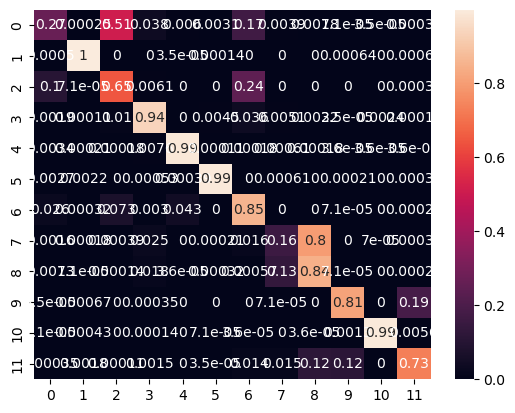

In [61]:
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassAccuracy

target = torch.tensor(targets)
preds = torch.tensor(preds)
metric = MulticlassConfusionMatrix(12, normalize='true')
res=metric(preds, target)

prec = MulticlassPrecision(12)
print('Precision: ',prec(preds, target))

rec=MulticlassRecall(12)
print('Recall: ', rec(preds, target))

f1=MulticlassF1Score(12)
print('F1-score: ', f1(preds, target))

acc2=MulticlassAccuracy(12)
print('Overall Accuracy: ', acc2(preds, target))

import seaborn as sn
sn.heatmap(res, annot=True)

___